In [30]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import xarray as xr
from skimage.morphology import binary_erosion, convex_hull_image, convex_hull_object
from matplotlib.colors import ListedColormap
import matplotlib.patches as pltpat
import math
import time
import random
from matplotlib import cm
from collections import deque
import matplotlib.patches as mpatches

from geopy.distance import lonlat, distance

from Astar_netcdf import AStarPlanner
from rrtstar_netcdf import RRTStar
from rrt_netcdf import RRT
show_animation = False

In [2]:
data = xr.open_dataset('wave2021.nc')
data_stat = xr.open_dataset('MED-MFC_006_017_mask_bathy.nc')
mask = data_stat.variables['mask'][0,:,:]
lats = data.variables['latitude'][:]
lons = data.variables['longitude'][:]
lons_mask = data_stat.variables['longitude'][:]
lats_mask = data_stat.variables['latitude'][:]
times = data.variables['time'][:]
# 2021-07-18, 2021-08-23, 2021-08-24, 2021-09-10, 2021-09-18, 
# 2021-10-11, 2021-10-22, 2021-10-27, 2021-10-31, 2021-11-05, 2021-12-18, 2021-03-07
july18 = data.sel(time='2021-09-10')  
wave = july18.variables['VHM0'][:]

july18

<xarray.Dataset>
Dimensions:    (latitude: 47, time: 24, longitude: 62)
Coordinates:
  * latitude   (latitude) float32 41.35 41.4 41.44 41.48 ... 43.19 43.23 43.27
  * time       (time) datetime64[ns] 2021-09-10 ... 2021-09-10T23:00:00
  * longitude  (longitude) float32 8.958 9.0 9.042 9.083 ... 11.42 11.46 11.5
Data variables:
    VHM0       (time, latitude, longitude) float32 ...
Attributes: (12/15)
    bulletin_type:                   forecast
    institution:                     Hellenic Centre for Marine Research (HCM...
    source:                          MEDWAM3
    credit:                          Copernicus Marine Environment Monitoring...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    producer:                        CMEMS-MED Monitoring and Forecasting Centre
    ...                              ...
    area:                            MED
    bulletin_date:                   2022-01-04 12
    FROM_ORIGINAL_FILE__field_type:  hourly_instantaneous_at_time_field
    title:                           Wave fields (2D) - Hourly Instantaneous
    _CoordSysBuilder:                ucar.nc2.dataset.conv.CF1Convention
    history:                         Data extracted from dataset http://local...

In [3]:
# general basemap of Italy configuration space
# mp = Basemap(projection='merc',
#              llcrnrlon=6.42,  
#              llcrnrlat=40.58, 
#              urcrnrlon=15.13, 
#              urcrnrlat=45.5488,  
#              resolution='i')

# lon, lat = np.meshgrid(lons, lats)   # 62 x 47
# x, y = mp(lon, lat)
# lon_mask, lat_mask = np.meshgrid(lons_mask, lats_mask)  # 1307 x 380
# x_mask, y_mask = mp(lon_mask, lat_mask)

# x_min, y_min = mp(lons.values[0], lats.values[0]) 
# x_max, y_max = mp(lons.values[-1], lats.values[-1]) 

# basemap for zoom plots
mp2 = Basemap(projection='merc',
             llcrnrlon=lons.values[0],  
             llcrnrlat=lats.values[0], 
             urcrnrlon=lons.values[-1], 
             urcrnrlat=lats.values[-1],  
             resolution='f')

lon, lat = np.meshgrid(lons, lats)   # 62 x 47
x, y = mp2(lon, lat)


s1x, s1y = mp2(lons.values[12], lats.values[7])
g1x, g1y = mp2(lons.values[50], lats.values[28])
g2x, g2y = mp2(lons.values[39], lats.values[33])

<ipython-input-5-729abc1f96e4>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c_scheme = mp.pcolor(x, y, wave[0], cmap='jet')


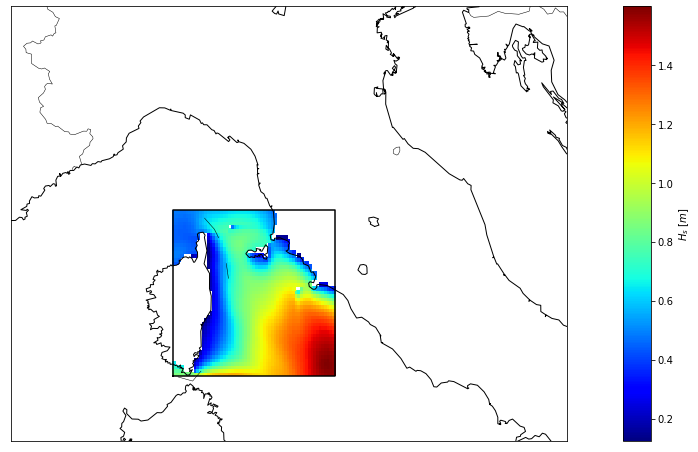

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

c_scheme = mp.pcolor(x, y, wave[0], cmap='jet')
cbar = mp.colorbar(c_scheme, location='right', pad='10%')
# plt.clim(0, 1)
cbar.set_label('$H_s$ $[m]$')
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [4]:
# convex_cost = np.zeros_like(wave[li:le])
# contour_raw_meteo_convex = np.zeros_like(wave[li:le])
#     convex_cost[i] = convex_hull_object(cost[i])
#     contour_raw_meteo_convex[i]=np.logical_xor(convex_cost[i],binary_erosion(convex_cost[i]))
li = 3   # 0   4(7-5)  4   3   2  -  5   11    0    0    3    6    3   
le = 17  # 15  18    18  17    15  - 17   23   12   12   15   18   15  
cost = np.zeros_like(wave[li:le])
contour_raw_meteo = np.zeros_like(wave[li:le])
contour_raw_land = np.logical_xor(mask,binary_erosion(mask)) 
for i in range(le-li):
    cost[i] = 100 * (np.array(wave[i+li]) > 0.8)
    contour_raw_meteo[i] = np.logical_xor(cost[i],binary_erosion(cost[i])) 


<ipython-input-61-d915e34a560d>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mp2.pcolor(x, y, cost[3], cmap=ListedColormap(['white', 'dodgerblue']), alpha=0.7)
<ipython-input-61-d915e34a560d>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mp2.pcolor(x, y, image, cmap=ListedColormap(['white', 'red']), alpha=0.5)


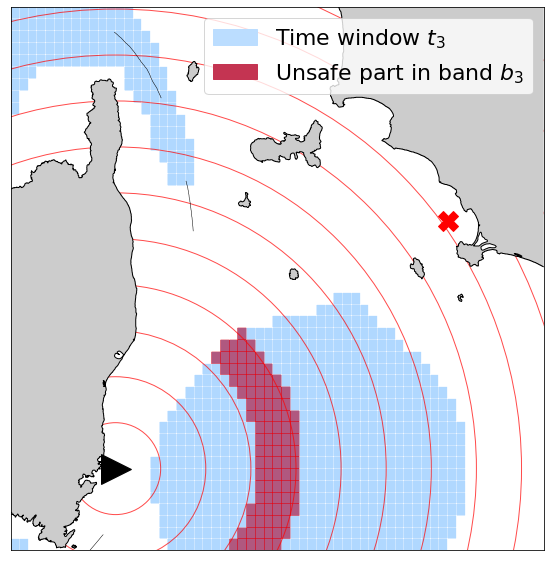

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
mp2.plot(sx_init, sy_init, ">k", markersize=30)
mp2.plot(gx_a, gy_a, "Xr", markersize=20)
mp2.pcolor(x, y, cost[3], cmap=ListedColormap(['white', 'dodgerblue']), alpha=0.7)
mp2.pcolor(x, y, image, cmap=ListedColormap(['white', 'red']), alpha=0.5)
# mp2.pcolor(x, y, cost[4], cmap=ListedColormap(['white', 'dodgerblue']), alpha=0.3)
# plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
for i in range(le-li):
    ax.add_patch(pltpat.Ellipse(xy=(sx_init, sy_init),width= 2*ww *(i+1), height=2*hh*(i+1),
                                color='red', alpha=0.7, fill = False))

loc_patch = mpatches.Patch(color='#bbddff', label="Time window $t_3$") #6cb6ff
impr1_patch = mpatches.Patch(color='#c43452', label="Unsafe part in band $b_3$") 
#a55884
handles, labels = ax.get_legend_handles_labels()
handles.append(loc_patch)
handles.append(impr1_patch)
ax.legend(handles=handles, loc="upper right", fontsize=22, markerscale=4)
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
plt.savefig("locboth3.png", dpi=300, bbox_inches='tight')
plt.show()

In [26]:
xspace = lons.values
yspace = lats.values

sx = xspace[12]   # 12
sy = yspace[7]    # 7
gx = xspace[50]   # 50  39
gy = yspace[28]   # 28  33
sx_init, sy_init = mp2(sx, sy)
gx_a, gy_a = mp2(gx, gy)

hh = 18000 / (distance(lonlat(*(lons.values[0],lats.values[0])), lonlat(*(lons.values[0],lats.values[-1]))).m / mp2(lons.values[-1],lats.values[-1])[1])
ww = 18000 / (distance(lonlat(*(lons.values[0],lats.values[0])), lonlat(*(lons.values[-1],lats.values[0]))).m / mp2(lons.values[-1],lats.values[-1])[0]) 

In [60]:
x_obsl, y_obsl = [], []  # contour land points
oxmeteo, oymeteo = [[] for i in range(le-li)], [[] for i in range(le-li)]     # all meteo points
oxmeteo_, oymeteo_ = [[] for i in range(le-li)], [[] for i in range(le-li)]   # all meteo points
x_obsm, y_obsm = [[] for i in range(le-li)], [[] for i in range(le-li)]       # contour meteo points
x_obsm_, y_obsm_ = [[] for i in range(le-li)], [[] for i in range(le-li)]       # contour meteo points
map_x, map_y = [], []  
map_x_, map_y_ = [], [] 
map_x2, map_y2 = [], []  
map_x_2, map_y_2 = [], [] 
# astar_contour = np.zeros_like(wave[:le])
image = np.zeros((47, 62))

for i in range(le-li):
    for k in np.arange(0,47,1):
        for j in np.arange(0,62,1):
            if cost[i][k][j] == 100:
                oxmeteo[i].append(lons.values[j])
                oymeteo[i].append(lats.values[k])
                geo_dist = distance(lonlat(*(lons.values[j],lats.values[k])), lonlat(*(sx,sy))).km
                if 18*(i) < geo_dist < 18*(i+1):
                    if i==3:
                        map_x.append(lons.values[j])
                        map_y.append(lats.values[k]) 
                        image[k][j] = 1
    oxmeteo_[i], oymeteo_[i] = mp2(oxmeteo[i], oymeteo[i]) 

for k in np.arange(0,380,1):
        for j in np.arange(0,1307,1):
            if lons_mask.values[650] <= lons_mask.values[j] <= lons_mask.values[711] and lats_mask.values[268] <= lats_mask.values[k] <= lats_mask.values[314]:                      
                if contour_raw_land[k][j]: 
                    if lons_mask.values[j] > 10:
                        x_obsl.append(lons_mask.values[j])
                        y_obsl.append(lats_mask.values[k])
    #                     map_x.append(lons_mask.values[j])
    #                     map_y.append(lats_mask.values[k])
#                         map_x2.append(lons_mask.values[j])
#                         map_y2.append(lats_mask.values[k])

map_x_, map_y_ = mp2(map_x, map_y)       # map contour points                
x_obsl_, y_obsl_ = mp2(x_obsl, y_obsl)       # coastline points

astar_contour = np.logical_xor(image,binary_erosion(image)) 
for k in np.arange(0,47,1):
        for j in np.arange(0,62,1):
            if astar_contour[k][j]:
                map_x2.append(lons.values[j])
                map_y2.append(lats.values[k]) 
map_x_2, map_y_2 = mp2(map_x2, map_y2)       # map contour points     

<ipython-input-17-b7b01a31c993>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mp.pcolor(x, y, cost[4], cmap=ListedColormap(['white', 'red']))


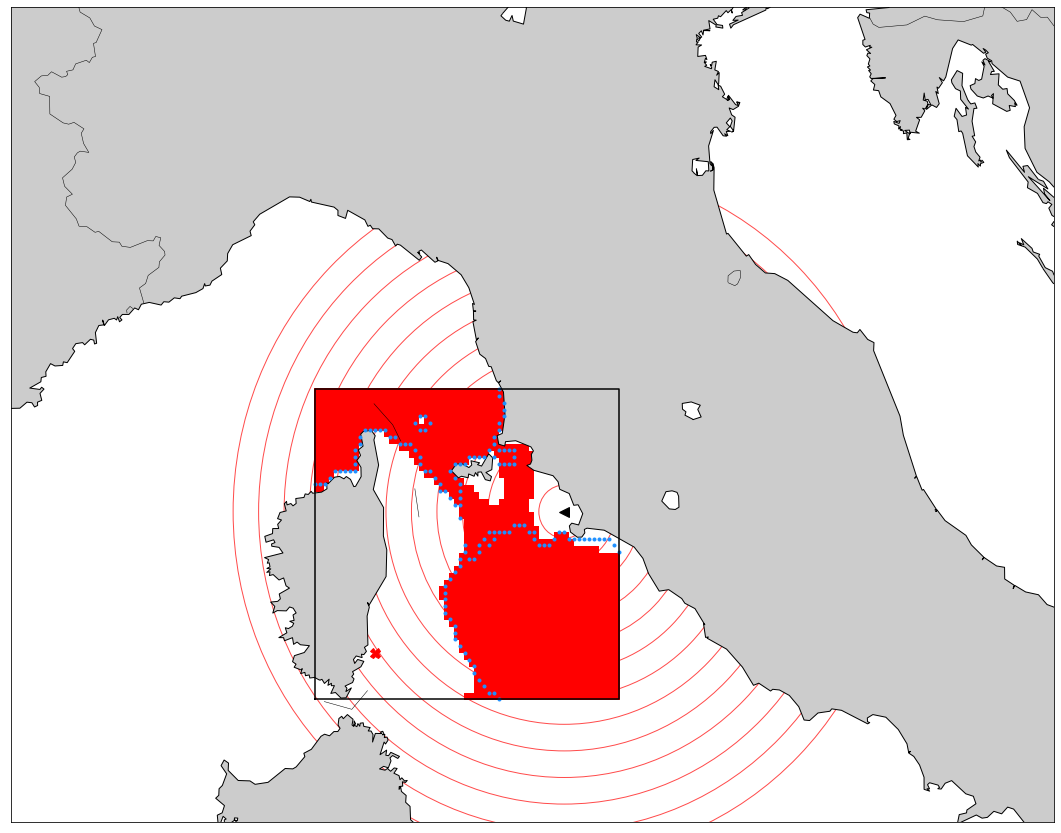

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
mp.plot(sx_init, sy_init, "<k", markersize=10)
plt.plot(gx_a, gy_a, "Xr", markersize=10)

# plt.scatter(x_obsl_, y_obsl_, color="peru")
plt.plot(map_x_2, map_y_2, '.', color="dodgerblue")  # label="Contour in $t_4$"
mp.pcolor(x, y, cost[4], cmap=ListedColormap(['white', 'red']))
# mp.pcolor(x, y, cost[7], cmap=ListedColormap(['white', 'red']),alpha=0.7, label="Time window $t_4$")
# mp2.pcolor(x, y, cost[4], cmap=ListedColormap(['white', 'dodgerblue']), alpha=0.2, label="Time window $t_5$") #vmin=0,vmax=1
# plt.scatter(map_x_, map_y_, color="dodgerblue", label="Obstacles in $t_4$")
# plt.plot(map_x_, map_y_, '.', color="aqua")
# hh = 18000 / (distance(lonlat(*(lons.values[0],lats.values[0])), lonlat(*(lons.values[0],lats.values[-1]))).m / mp2(lons.values[-1],lats.values[-1])[1])
# ww = 18000 / (distance(lonlat(*(lons.values[0],lats.values[0])), lonlat(*(lons.values[-1],lats.values[0]))).m / mp2(lons.values[-1],lats.values[-1])[0]) 
hh = 18000 / (distance(lonlat(*(6.42,40.58)), lonlat(*(6.42,45.5488))).m / mp(15.13,45.5488)[1])
ww = 18000 / (distance(lonlat(*(6.42,40.58)), lonlat(*(15.13,40.58))).m / mp(15.13,45.5488)[0])
for i in range(le-li):
    ax.add_patch(pltpat.Ellipse(xy=(sx_init, sy_init),width= 2*ww *(i+1), height=2*hh*(i+1),
                                color='red', alpha=0.7, fill = False))

plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
# mp.pcolor(x, y, cost[1], cmap=ListedColormap(['white', 'red']))
# ax.legend(loc="upper right", fontsize=25, markerscale=4)
mp.fillcontinents()
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
# plt.savefig("localexample3.png", dpi=300)
plt.show()

In [495]:
grid_size = 0.04166
robot_radius = grid_size
start_time = time.time()
a_star = AStarPlanner(map_x2, map_y2, grid_size, robot_radius, xspace[0], yspace[0], xspace[-1], yspace[-1])
rx, ry = a_star.planning(sx, sy, gx, gy)
print("Computational time is {} seconds".format(round(time.time() - start_time,3)))
rx = list(reversed(rx))
ry = list(reversed(ry))

min_x: 8.958333969116211°
min_y: 41.35416793823242°
max_x: 11.500000953674316°
max_y: 43.27083206176758°
x_width: 62
y_width: 47
Find goal
Computational time is 2.915 seconds


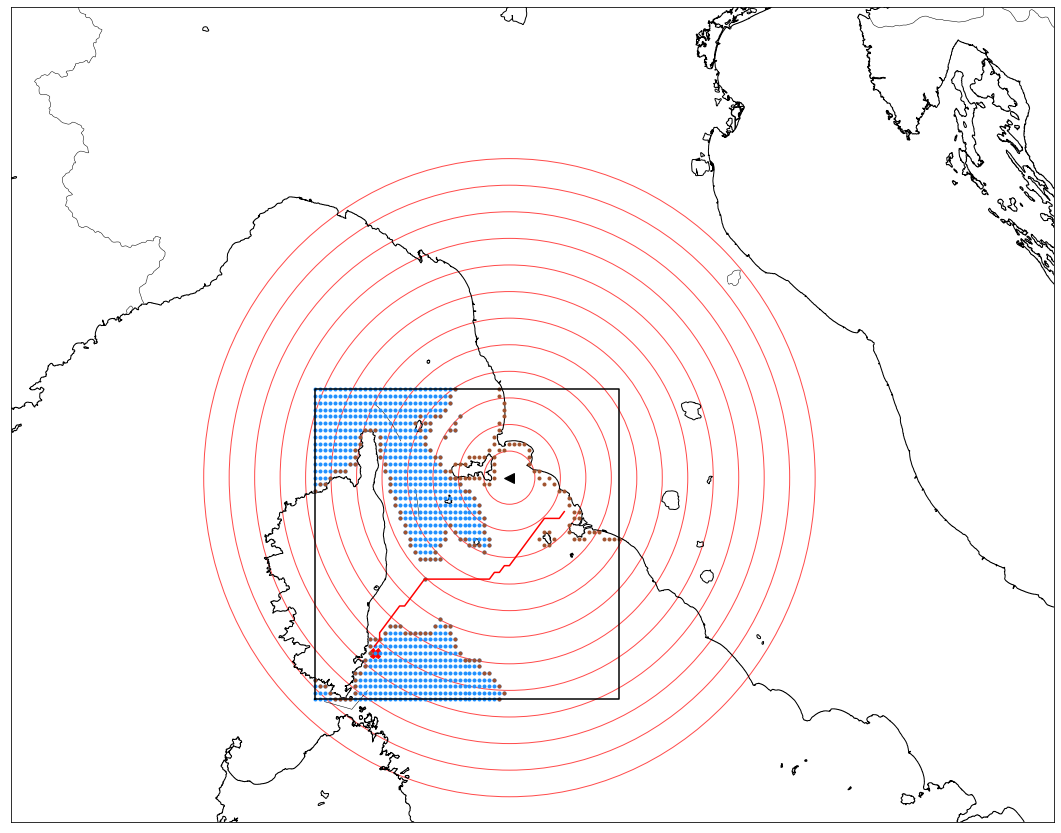

In [674]:
rx_, ry_ = mp(rx, ry)

fig, ax = plt.subplots(1, 1, figsize=(20, 15))
mp.plot(sx_init, sy_init, "<k", markersize=10)
mp.plot(gx_a, gy_a, "Xr", markersize=10)
plt.plot(map_x_, map_y_, '.', color="dodgerblue")
plt.plot(map_x_2, map_y_2, '.', color="sienna")
for i in range(le-li):
    ax.add_patch(pltpat.Ellipse(xy=(sx_init, sy_init),width= 2*ww *(i+1), height=2*hh*(i+1),
                                color='red', alpha=0.7, fill = False))

mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")

mp.plot(rx_, ry_, '-r')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [498]:
path_dist = 0
for i in range(len(rx)-1):
    path_dist += distance(lonlat(*(rx[i],ry[i])), lonlat(*(rx[i+1],ry[i+1]))).km
print("Travel time = ", str(round(path_dist/18,4)), "hours")

Travel time =  9.9806 hours


In [499]:
# locpatha50 = [[] for i in range(12)]  # 5 for 5 day missions
locpatha50[1] = [rx,ry]

In [491]:
locpatha39[1] = [rx,ry]

In [380]:
len(locpatha50)

12

In [86]:
locpatha39 = [[] for i in range(12)]
locpatha39[0] = [rx,ry]

In [501]:
import pickle
file_name = "locpatha50.pkl"
open_file = open(file_name, "wb")
pickle.dump(locpatha50, open_file)
open_file.close()

# file_name = "locpatha1.pkl"
# open_file = open(file_name, "rb")
# locpatha1 = pickle.load(open_file)
# open_file.close()

## RRT*

In [847]:
x_obsl, y_obsl = [], []
Cspacex, Cspacey = [], []

x_obsm, y_obsm = [[] for i in range(le-li)], [[] for i in range(le-li)]       # contour meteo points
x_obsm_, y_obsm_ = [[] for i in range(le-li)], [[] for i in range(le-li)]     # contour meteo points

for i in range(le-li):
    for k in np.arange(0,47,1):
        for j in np.arange(0,62,1):
            if contour_raw_meteo[i][k][j]:
                x_obsm[i].append(lons.values[j])
                y_obsm[i].append(lats.values[k])
    
    x_obsm_[i], y_obsm_[i] = mp(x_obsm[i], y_obsm[i])       # meteo contour points
    
for k in np.arange(0,380,1):
        for j in np.arange(0,1307,1):
            if lons_mask.values[650] <= lons_mask.values[j] <= lons_mask.values[711] and lats_mask.values[268] <= lats_mask.values[k] <= lats_mask.values[314]:                      
                if contour_raw_land[k][j]: 
                    if lons_mask.values[j] > 10:
                        x_obsl.append(lons_mask.values[j])
                        y_obsl.append(lats_mask.values[k])
                if mask.values[k][j] == 1:
                    Cspacex.append(lons_mask.values[j])
                    Cspacey.append(lats_mask.values[k])
Cspacex_, Cspacey_ = mp(Cspacex, Cspacey)                   
x_obsl_, y_obsl_ = mp(x_obsl, y_obsl)       # coastline points

In [848]:
sx = xspace[39]  
sy = yspace[33] 
gx = xspace[12]   # 50  39
gy = yspace[7]   # 28  33
sx_init, sy_init = mp(sx, sy)
gx_a, gy_a = mp(gx, gy)
grid_size = 4500

# obstacle_list = [[] for i in range(le-li)]

# for i in range(le-li):
#     for j, _ in enumerate(x_obsm_[i]):
#         obstacle_list[i].append([x_obsm_[i][j], y_obsm_[i][j], grid_size])
#     for k, _ in enumerate(x_obsl_):
#         obstacle_list[i].append([x_obsl_[k], y_obsl_[k], grid_size])   

obstacle_list = [[] for i in range(2)]
for j in range(2):
    for i in range(len(map_x_2)):
        obstacle_list[j].append([map_x_2[i], map_y_2[i], grid_size])

In [849]:
try:
    from rrt_netcdf import RRT
except ImportError:
    raise

show_animation = False


class RRTStar(RRT):
    """
    Class for RRT Star planning
    """

    class Node(RRT.Node):
        def __init__(self, x, y):
            super().__init__(x, y)
            self.cost = 0.0  # taking into account the cost

    def __init__(self,
                 start,
                 goal,
                 obstacle_list,
                 rand_area,
                 c_spacex,
                 c_spacey,
                 k,
                 connect_circle_dist,
                 expand_dis,
                 speed,
                 path_resolution,
                 goal_sample_rate,
                 max_iter=3000,
                 # RRT* parameter: planning constant for the recomputing of the cost
                 search_until_max_iter=False):
        """
        Setting Parameter

        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacleList:obstacle Positions [[x,y,size],...]
        randArea:Random Sampling Area [min,max]

        """
        super().__init__(start, goal, obstacle_list, rand_area, c_spacex, c_spacey, k, expand_dis, speed, path_resolution,
                         goal_sample_rate, max_iter)
        self.connect_circle_dist = connect_circle_dist
        self.goal_node = self.Node(goal[0], goal[1])
        self.search_until_max_iter = search_until_max_iter

    def planning(self, animation=True):
        """
        rrt star path planning

        animation: flag for animation on or off .
        """
        v = 0
        self.node_list = [self.start]
        for i in range(self.max_iter):
            # print("Iter:", i, ", number of nodes:", len(self.node_list))
            rnd = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd)  # nearest index
            near_node = self.node_list[nearest_ind]  # nearest node of the list to the rnd point just found
            new_node = self.steer(near_node, rnd, self.expand_dis)  # at each iter new node change of expand_dis

            # adding cost from the near node and random node
            temp1 = mp(near_node.x, near_node.y, inverse=True)
            temp2 = mp(new_node.x, new_node.y, inverse=True)
            new_node.cost = near_node.cost + distance(lonlat(*temp1), lonlat(*temp2)).m

            # new_node.cost = near_node.cost + math.hypot(new_node.x-near_node.x, new_node.y-near_node.y)
            if self.check_collision(new_node, self.obstacle_list[self.k-1]):
                near_inds = self.find_near_nodes(new_node)  # now we have the indexes of nodes near new_node
                node_with_updated_parent = self.choose_parent(new_node, near_inds)  # arguments: new node and indexes
                if node_with_updated_parent:
                    self.rewire(node_with_updated_parent, near_inds)
                    self.node_list.append(node_with_updated_parent)
                else:
                    self.node_list.append(new_node)
            # mp(new_node.x, new_node.y, inverse=True)

            """if new_node.cost/5 > 3600*self.k:  # comment if global planning
                self.k += 1"""

                # if self.k > 14:
                #    self.k = 14

            if animation:
                v = self.draw_graph(self.obstacle_list[self.k-1], v, rnd)

            if (not self.search_until_max_iter) and new_node:  # if reaches goal
                last_index = self.search_best_goal_node()
                if last_index is not None:
                    return self.generate_final_course(last_index), new_node.cost, i

        print("reached max iteration")

        last_index = self.search_best_goal_node()   # if I want to search until reached max iteration
        if last_index is not None:
            return self.generate_final_course(last_index)

        return None

    def choose_parent(self, new_node, near_inds):
        """
        Computes the cheapest point to new_node contained in the list
        near_inds and set such a node as the parent of new_node.
            Arguments:
            --------
                new_node, Node
                    randomly generated node with a path from its neared point
                    There are not coalitions between this node and the tree.
                near_inds: list
                    Indices of indices of the nodes what are near to new_node

            Returns.
            ------
                Node, a copy of new_node
        """
        if not near_inds:
            return None

        # search nearest cost in near_inds
        costs = []
        for i in near_inds:  # in a for loop
            near_node = self.node_list[i]  # the near node is each of the list with the corresponding list
            t_node = self.steer(near_node, new_node)  # it finds the node attached to new_node and define parent near_n
            if t_node and self.check_collision(t_node, self.obstacle_list[self.k-1]):
                costs.append(self.calc_new_cost(near_node, new_node))  # the function calc the cost as a distance
            else:  # costs is a list
                costs.append(float("inf"))  # the cost of collision node
        min_cost = min(costs)

        if min_cost == float("inf"):
            print("There is no good path.(min_cost is inf)")
            return None

        min_ind = near_inds[costs.index(min_cost)]  # find the index of near node (in the ball) with min cost
        new_node = self.steer(self.node_list[min_ind], new_node)  # segment between the min cost node and new node
        new_node.cost = min_cost

        return new_node

    def search_best_goal_node(self):
        #  compute the distance of each node from the goal
        dist_to_goal_list = [self.calc_dist_to_goal(n.x, n.y) for n in self.node_list]
        #  if the distance if smaller than expand dis -> add the relative index to the goal_inds list
        goal_inds = [dist_to_goal_list.index(i) for i in dist_to_goal_list if i <= self.expand_dis]

        safe_goal_inds = []
        for goal_ind in goal_inds:
            t_node = self.steer(self.node_list[goal_ind], self.goal_node)
            if self.check_collision(t_node, self.obstacle_list[self.k-1]):
                safe_goal_inds.append(goal_ind)

        if not safe_goal_inds:
            return None

        min_cost = min([self.node_list[i].cost for i in safe_goal_inds])
        for i in safe_goal_inds:
            if self.node_list[i].cost == min_cost:
                return i

        return None

    def find_near_nodes(self, new_node):
        """
        1) defines a ball centered on new_node
        2) Returns all nodes of the tree that are inside this ball
            Arguments:
            ---------
                new_node: Node
                    new randomly generated node, without collisions between
                    its nearest node
            Returns:
            -------
                list
                    List with the indices of the nodes inside the ball of
                    radius r
        """
        nnode = len(self.node_list) + 1
        r = self.connect_circle_dist * math.sqrt((math.log(nnode) / nnode))
        # if expand_dist exists, search vertices in a range no more than expand_dist
        # if hasattr(self, 'expand_dis'):
        #    r = max(r, self.expand_dis)
        dist_list = [(node.x - new_node.x)**2 + (node.y - new_node.y)**2
                     for node in self.node_list]  # compute distance of each node from the new_node
        near_inds = [dist_list.index(i) for i in dist_list if i <= r**2]
        return near_inds  # returns the index list of those points with a distance smaller than the ball radius

    def rewire(self, new_node, near_inds):
        """
            For each node in near_inds, this will check if it is cheaper to
            arrive to them from new_node.
            In such a case, this will re-assign the parent of the nodes in
            near_inds to new_node.
            Parameters:
            ----------
                new_node, Node
                    Node randomly added which can be joined to the tree

                near_inds, list of uints
                    A list of indices of the self.new_node which contains
                    nodes within a circle of a given radius.
            Remark: parent is designated in choose_parent.

        """
        for i in near_inds:
            near_node = self.node_list[i]
            edge_node = self.steer(new_node, near_node)
            if not edge_node:
                continue
            # calc the cost as distance from node with new parent and nodes in the ball
            edge_node.cost = self.calc_new_cost(new_node, near_node)

            no_collision = self.check_collision(edge_node, self.obstacle_list[self.k-1])
            improved_cost = near_node.cost > edge_node.cost  # can be True or False

            if no_collision and improved_cost:  # if True change near node with edge node
                near_node.x = edge_node.x
                near_node.y = edge_node.y
                near_node.cost = edge_node.cost
                near_node.path_x = edge_node.path_x
                near_node.path_y = edge_node.path_y
                near_node.parent = edge_node.parent
                self.propagate_cost_to_leaves(new_node)

    def calc_new_cost(self, from_node, to_node):
        #d, _ = self.calc_distance_and_angle(from_node, to_node)
        temp1 = mp(from_node.x, from_node.y, inverse=True)
        temp2 = mp(to_node.x, to_node.y, inverse=True)
        d = distance(lonlat(*temp1), lonlat(*temp2)).m
        return from_node.cost + d

    def propagate_cost_to_leaves(self, parent_node):  # a recursive way to compute the cost of the path till the start

        for node in self.node_list:
            if node.parent == parent_node:
                node.cost = self.calc_new_cost(parent_node, node)
                self.propagate_cost_to_leaves(node)


In [850]:
# rrt = RRT(
#         start=[sx_init, sy_init],
#         goal=[gx_a, gy_a],
#         rand_area=[x_min, x_max, y_min, y_max],
#         c_spacex = Cspacex_,
#         c_spacey = Cspacey_,
#         obstacle_list=obstacle_list,
#         expand_dis=5000,
#         path_resolution=2500,  # changing path resolution reduces a lot the computation time
#         speed = 5,
#         goal_sample_rate=10) 
# path_rrt, dist_tot = rrt.planning(animation=show_animation)

In [851]:
rrt_star = RRTStar(
            start=[sx_init, sy_init],
            goal=[gx_a, gy_a],
            rand_area=[x_min, x_max, y_min, y_max],
            obstacle_list=obstacle_list,
            c_spacex = Cspacex_,
            c_spacey = Cspacey_,
            k = 1,
            speed = 5,
            path_resolution=4500.0,
            connect_circle_dist=150000,
            goal_sample_rate=15,
            expand_dis=4500)

In [855]:
start_time = time.time()
path_star, cost_tot, iter_tot = rrt_star.planning(animation=show_animation)
path_star = list(reversed(path_star))
end_time = time.time()
if path_star is None:
    print("Cannot find path")
else:
    print("Found path!!")

print("The computational time is " + str(round(end_time - start_time, 4)) + " seconds")
# print("Travel time = ", str(round(cost_tot/5/3600,4)), "hours")

Found path!!
The computational time is 4.0472 seconds


In [1551]:
# path_dist = 0
# for i in range(len(path_star)-1):
#     path_dist += np.hypot(path_star[i][0] - path_star[i+1][0],path_star[i][1] - path_star[i+1][1])
# print("Travel time = ", str(round(path_dist/1000/18,4)), "hours")    
path_star = locbandrrt39[4]

In [1552]:
path_starcoord = np.zeros_like(path_star)
for i in range(len(path_star)):
    path_starcoord[i][0], path_starcoord[i][1]  = mp(path_star[i][0], path_star[i][1], inverse=True)

path_dist = 0
for i in range(len(path_starcoord)-1):
    path_dist += distance(lonlat(*(path_starcoord[i][0],path_starcoord[i][1])), 
                          lonlat(*(path_starcoord[i+1][0],path_starcoord[i+1][1]))).km
print("Travel time = ", str(round(path_dist/18,4)), "hours")

Travel time =  8.4558 hours


<ipython-input-1550-0e3c70d6d001>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mp.pcolor(x, y, cost[2], cmap=ListedColormap(['white', 'red']),alpha=0.7, label="Time window $t_4$")


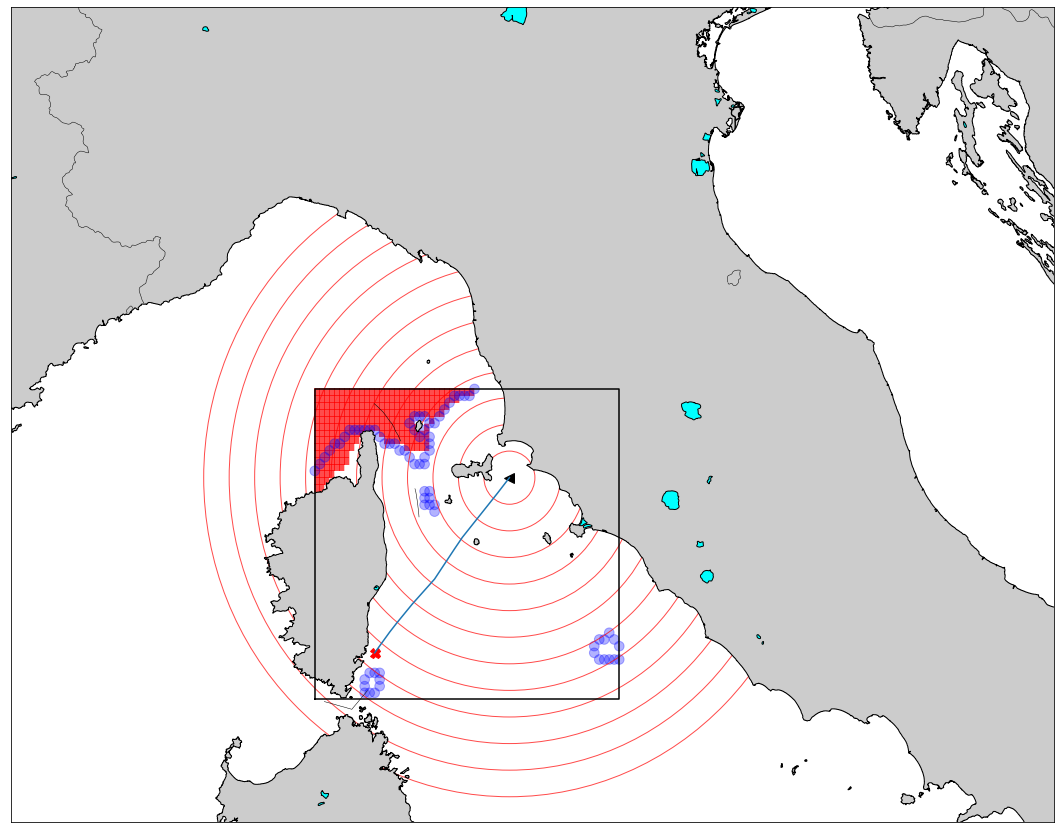

In [1550]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))

num = 0
plt.plot(sx_init, sy_init, "<k", markersize=10)
plt.plot(gx_a, gy_a, "Xr", markersize=10)
for i in range(len(obstacle_list[num])):
    ax.add_patch(plt.Circle(xy=(obstacle_list[num][i][0], obstacle_list[num][i][1]), radius=4500,
                            color='b', alpha=0.3))
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
plt.plot([x for (x, y) in locbandrrt39[4]], [y for (x, y) in locbandrrt39[4]], '-',label='RRT*')
# mp.plot(rx_, ry_, '-r',label='A*')
# plt.plot(map_x_, map_y_, '.', color="dodgerblue")
# plt.plot(map_x_2, map_y_2, '.', color="sienna")
# ax.legend(prop={"size":20})
mp.pcolor(x, y, cost[2], cmap=ListedColormap(['white', 'red']),alpha=0.7, label="Time window $t_4$")
for i in range(le-li):
    ax.add_patch(pltpat.Ellipse(xy=(sx_init, sy_init),width= 2*ww *(i+1), height=2*hh*(i+1),
                                color='red', alpha=0.7, fill = False))
mp.fillcontinents(lake_color='aqua')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [52]:
# locpathrrt1 = [[] for i in range(5)]  # 5 for 5 day missions
# locpathrrt2 = [[] for i in range(5)]

In [770]:
# locbandrrt50 = [[] for i in range(12)]  # 5 for 5 day missions
# locbandrrt39 = [[] for i in range(12)]
# len(locbandrrt50)
# locbandrrt39[8]

In [843]:
locbandrrt50[11] = path_star

In [860]:
locbandrrt39[11] = path_star

In [784]:
# locbandrrt2.append(path_star)
len(locbandrrt39[9])

13

In [1547]:
import pickle

file_name = "locbandrrt39.pkl"
open_file = open(file_name, "wb")
pickle.dump(locbandrrt39, open_file)
open_file.close()

# file_name = "locbandrrt1.pkl"
# open_file = open(file_name, "rb")
# locbandrrt1 = pickle.load(open_file)
# open_file.close()

## APF

In [14]:
convex_cost = convex_hull_object(image)
convex_cost_contour = np.logical_xor(convex_cost,binary_erosion(convex_cost)) 
oxmeteo_cx, oymeteo_cx = [], []
oxmeteo_cx_cont, oymeteo_cx_cont = [], []
for k in np.arange(0,47,1):
    for j in np.arange(0,62,1):
        if convex_cost[k][j] == 1:
            oxmeteo_cx.append(lons.values[j])
            oymeteo_cx.append(lats.values[k])
        if convex_cost_contour[k][j] == 1:
            oxmeteo_cx_cont.append(lons.values[j])
            oymeteo_cx_cont.append(lats.values[k])
            
oxmeteo_cx_, oymeteo_cx_ = mp(oxmeteo_cx, oymeteo_cx)
oxmeteo_cx_cont_, oymeteo_cx_cont_ = mp(oxmeteo_cx_cont, oymeteo_cx_cont)

In [169]:
centroid = [0 for i in range(l)]
for i in range(l):
    centroid[i] = (sum(oxmeteo_[i]) / len(oxmeteo_[i]), sum(oymeteo_[i]) / len(oymeteo_[i]))

In [188]:
print(centroid[0][0])
print(centroid[0][1])
print(centroid[1][0])
print(centroid[1][1])

468813.1510009972
198262.94132214287
468284.3973326916
196352.87472691102


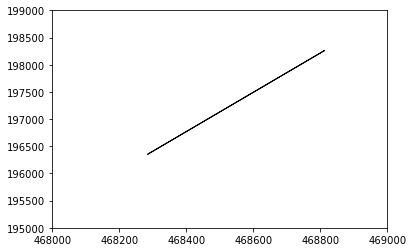

In [184]:
import math
a = [centroid[0][0],centroid[0][1]]
b = [centroid[1][0],centroid[1][1]]

head_length = 0.7

dx = b[0] - a[0]
dy = b[1] - a[1]

vec_ab = [dx,dy]

vec_ab_magnitude = math.sqrt(dx**2+dy**2)

dx = dx / vec_ab_magnitude
dy = dy / vec_ab_magnitude

vec_ab_magnitude = vec_ab_magnitude - head_length

ax = plt.axes()

ax.arrow(a[0], a[1], vec_ab_magnitude*dx, vec_ab_magnitude*dy, head_width=1, head_length=1, fc='lightblue', ec='black')

plt.xlim(468000,469000)
plt.ylim(195000,199000)
plt.show()


In [202]:
X = np.array((centroid[0][0]))
Y= np.array((centroid[0][1]))
U = np.array(500000)
V = np.array(250000)
U

array(500000)

In [201]:
y_max

402247.9709043745

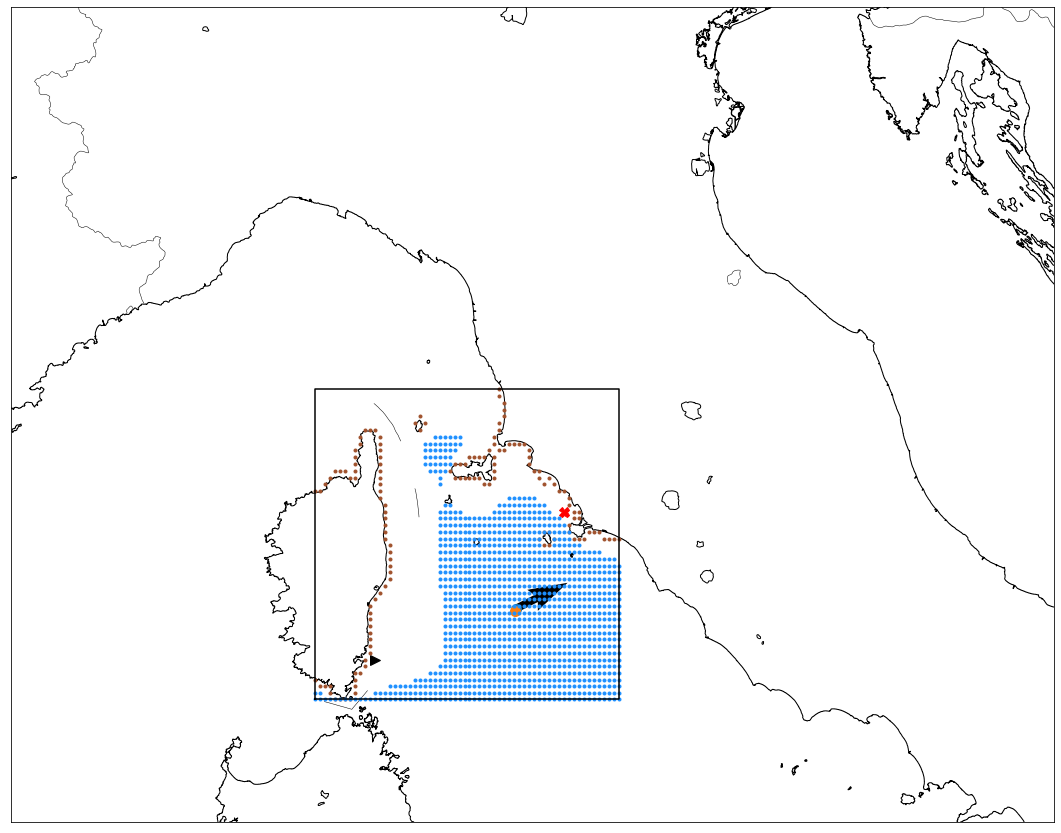

In [203]:
plt.figure(1, figsize=(20, 15))

plt.plot(sx_init, sy_init, ">k", markersize=10)
plt.plot(gx_a, gy_a, "Xr", markersize=10)
plt.plot(x_obsl_, y_obsl_, '.', color="sienna")
for i in range(2): 
     plt.plot(centroid[i][0], centroid[i][1], '.', markersize=20)
plt.quiver(*(centroid[0][0],centroid[0][1]), U, V)

# plt.plot(oxmeteo_cx_cont_, oymeteo_cx_cont_, '.', color="sienna")
# plt.plot(oxmeteo_cx_, oymeteo_cx_, '.', color="dodgerblue")
plt.plot(oxmeteo_[0], oymeteo_[0], '.', color="dodgerblue")
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

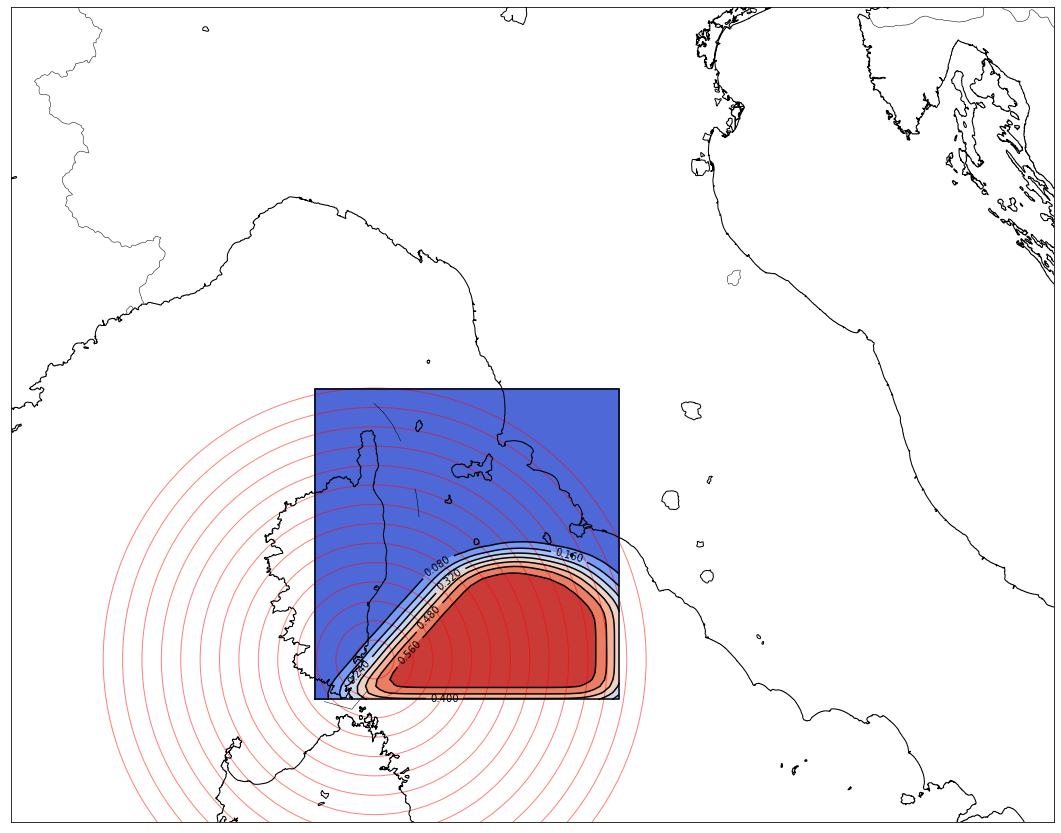

In [46]:
import scipy.stats as st

ux = xspace
uy = yspace
uxs, uys = np.meshgrid(ux, uy)
uxs_, uys_ = mp(uxs, uys)
f = []
positions = np.vstack([uxs.ravel(), uys.ravel()])
#values = np.vstack([map_x2 + map_x, map_y2 + map_y])
values = np.vstack([oxmeteo_cx, oymeteo_cx])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, uxs.shape)
f_tot = f
    

fig, ax = plt.subplots(1, 1, figsize=(20, 15))
ax = plt.axes()
ax.contourf(uxs_, uys_, f_tot, cmap='coolwarm')
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
cset = ax.contour(uxs_, uys_, f_tot, colors='k')
ax.clabel(cset, inline=1, fontsize=10)
for i in range(14):
    ax.add_patch(plt.Circle(xy=(sx_init, sy_init), radius=18000*(i+1),
                                color='red', alpha=0.5,fill = False))
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [135]:
sx = xspace[12]  
sy = yspace[6] 
gx = xspace[50]   # 50
gy = yspace[28]   # 28
sx_init, sy_init = mp(sx, sy)
gx_a, gy_a = mp(gx, gy)

start = (sx, sy)
goal = (gx, gy)
grid_size = 0.04166
q_g = grid_size*5
k_att = 300

robot_radius = grid_size
ox = x_obsl
oy = y_obsl
xw = 62
yw = 47

In [136]:
def comb_attractive_potential(x, y, gp, q_g):
    d_g = np.sqrt((x - gp[0]) ** 2 + (y - gp[1]) ** 2)
    if d_g <= grid_size/2:
        d_g = grid_size/2
    if d_g <= q_g: # quadratic range
        att_pot = 0.5 * k_att * d_g ** 2
    else:
        att_pot = q_g * k_att * d_g - 0.5 * k_att * q_g ** 2
    return att_pot

def calc_repulsive_potential(x, y, ox, oy, rr):
    # search nearest obstacle
    minid = -1
    dmin = float("inf")
    for i, _ in enumerate(ox):
        d = np.hypot(x - ox[i], y - oy[i])
        if dmin >= d:
            dmin = d
            minid = i

    # calc repulsive potential
    dq = np.hypot(x - ox[minid], y - oy[minid])

    if dq <= rr:
        
        if dq <= grid_size/2:
            dq = grid_size/2

        return 0.5 * 1 * (1.0 / dq - 1.0 / rr) ** 2
    else:
        return 0.0
    
pmap = [[0.0 for i in range(xw)] for i in range(yw)]

for i in range(l):
    for ix in range(xw):
        x = ix * grid_size + xspace[0]
        for iy in range(yw):
            y = iy * grid_size + yspace[0]
            ug = comb_attractive_potential(x, y, goal, q_g)
            uo_land = calc_repulsive_potential(x, y, x_obsl, y_obsl, robot_radius)/10
            uf = ug + uo_land
            pmap[iy][ix] = uf
plot_map1 =  np.array(pmap) + f_tot*50
# f_tot repulsive potential of waves

<ipython-input-137-0d2e82a7b58f>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(uxs_, uys_, plot_map1, cmap=cm.YlOrBr)


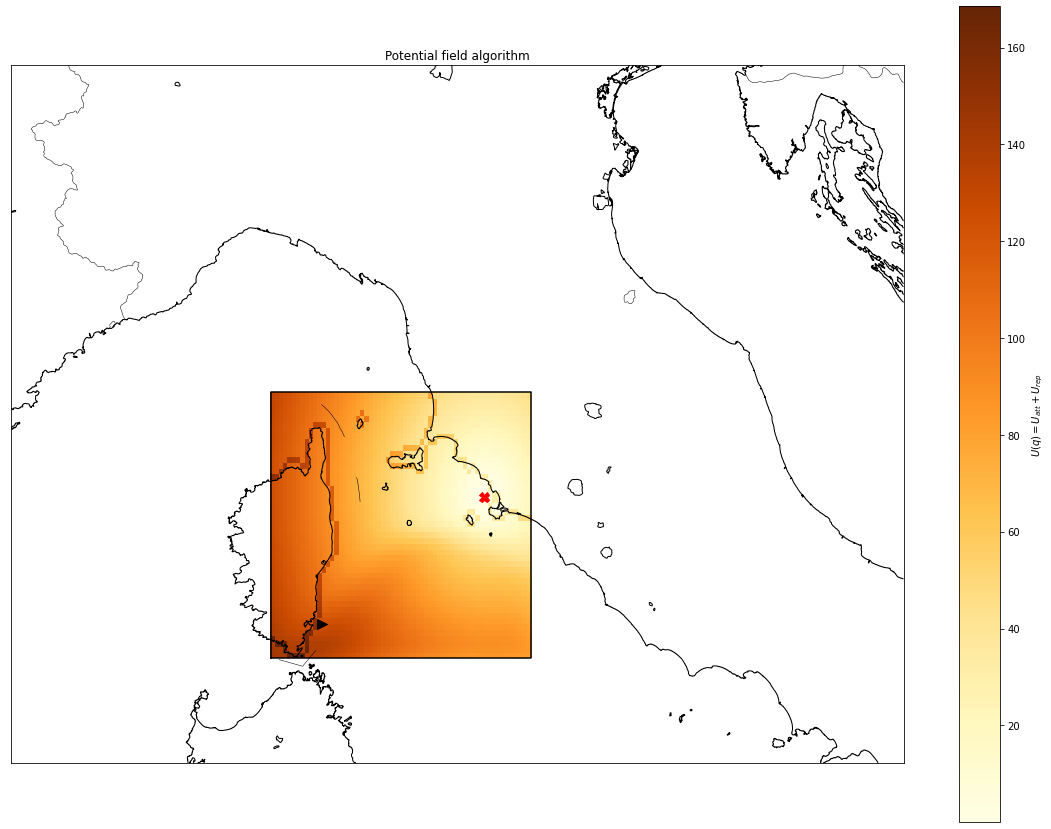

In [137]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
plt.pcolor(uxs_, uys_, plot_map1, cmap=cm.YlOrBr)
c_bar = plt.colorbar()
c_bar.set_label('$U(q)=U_{att}+U_{rep}$')
plt.plot(sx_init, sy_init, ">k", markersize=10)
plt.plot(gx_a, gy_a, "Xr", markersize=10)
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.title('Potential field algorithm')
ax.set_aspect('equal', adjustable='box')
plt.show()

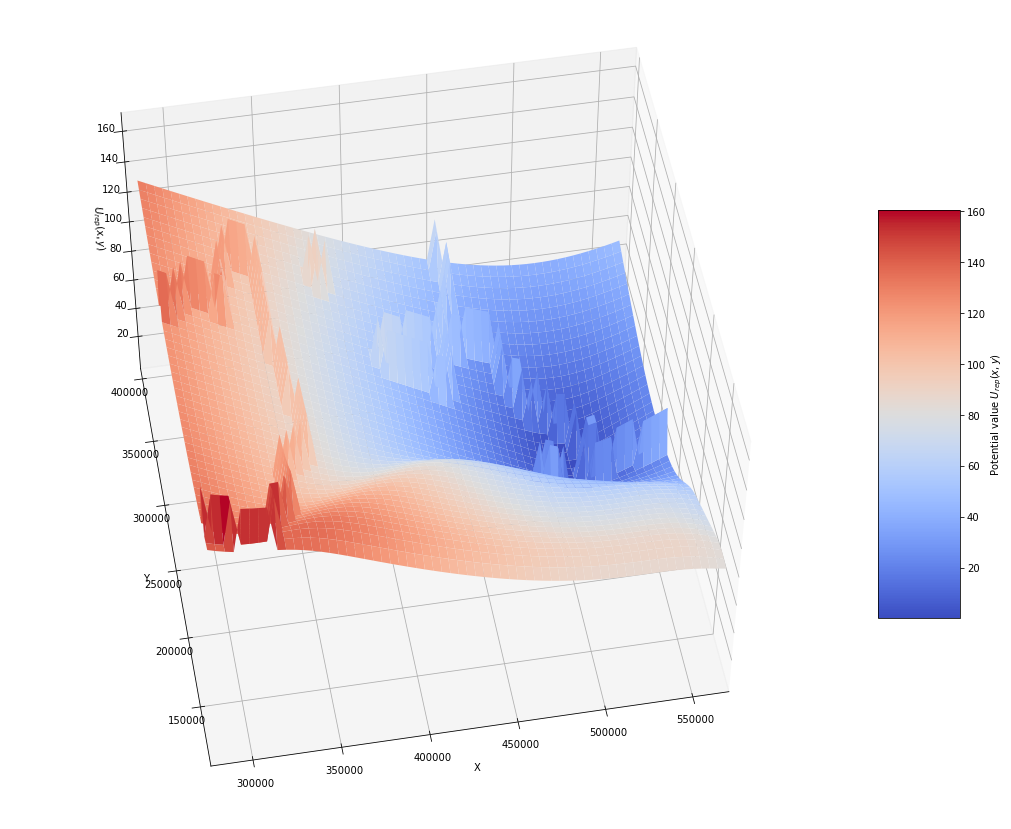

In [138]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(uxs_, uys_, plot_map1, rstride=1, cstride=1, cmap='coolwarm')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plt.colorbar(surf, shrink=0.5, aspect=5, label='Potential value $U_{rep}(x,y)$') # add color bar indicating the PDF
ax.view_init(50, -100)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('$U_{rep}(x,y)$')
plt.show()

In [139]:
OSCILLATIONS_DETECTION_LENGTH = 5

def calc_dist_from_start(x, y, s):
    a1 = mp(s[0], s[1], inverse=True)
    b1 = mp(x, y, inverse=True)
    
    return distance(lonlat(*a1), lonlat(*b1)).m

def get_motion_model():
    motion = [[1, 0],
              [0, 1],
              [-1, 0],
              [0, -1],
              [-1, -1],
              [-1, 1],
              [1, -1],
              [1, 1]]

    return motion


def oscillations_detection(previous_ids, ix, iy):
    previous_ids.append((ix, iy))

    if (len(previous_ids) > OSCILLATIONS_DETECTION_LENGTH):
        previous_ids.popleft()

    # check if contains any duplicates by copying into a set
    previous_ids_set = set()
    for index in previous_ids:
        if index in previous_ids_set:
            return True
        else:
            previous_ids_set.add(index)
    return False


def potential_field_planning(s, g, reso, rr, xm, ym, pmap):
    d = np.hypot(s[0] - g[0], s[1] - g[1])
    ix = round((s[0] - xm) / reso)
    iy = round((s[1] - ym) / reso)
    gix = round((g[0] - xm) / reso)
    giy = round((g[1] - ym) / reso)

    rx, ry = [s[0]], [s[1]]
    motion = get_motion_model()
    previous_ids = deque()
    
    while d >= reso:
        minp = float("inf")
        minix, miniy = -1, -1
        for i, _ in enumerate(motion):
            inx = int(ix + motion[i][0])
            iny = int(iy + motion[i][1])
            if iny >= len(pmap) or inx >= len(pmap[0]) or inx < 0 or iny < 0:
                p = float("inf")  # outside area
                print("outside potential!")
            else:
                p = pmap[iny][inx]
            if minp > p:
                minp = p
                minix = inx
                miniy = iny
        ix = minix
        iy = miniy
        xp = ix * reso + xm
        yp = iy * reso + ym
        d = np.hypot(g[0] - xp, g[1] - yp)
        rx.append(xp)
        ry.append(yp)

        if (oscillations_detection(previous_ids, ix, iy)):
            print("Oscillation detected at ({},{})!".format(ix, iy))
            break
    
    distance = calc_dist_from_start(xp, yp, s)
        
    if d < grid_size:
        print("The robot is arrived at the final point!")
    else:
        print("The robot got lost!")

    return rx, ry, d, distance

In [140]:
d = np.hypot(start[0] - goal[0], start[1] - goal[1])
print("Distance from start to goal is: " + str(d) + "°")

Distance from start to goal is: 1.8295408°


In [141]:
start_time = time.time()
path_x, path_y, d_update, new_distance = potential_field_planning(start, goal, grid_size, robot_radius, xspace[0], yspace[0], plot_map1)
print("Computational time is {} seconds".format(time.time() - start_time))

The robot is arrived at the final point!
Computational time is 0.003009319305419922 seconds


In [142]:
path_x_, path_y_ = mp(path_x, path_y)

<ipython-input-143-643040c44fbf>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(uxs_, uys_, plot_map1, cmap=cm.YlOrBr)


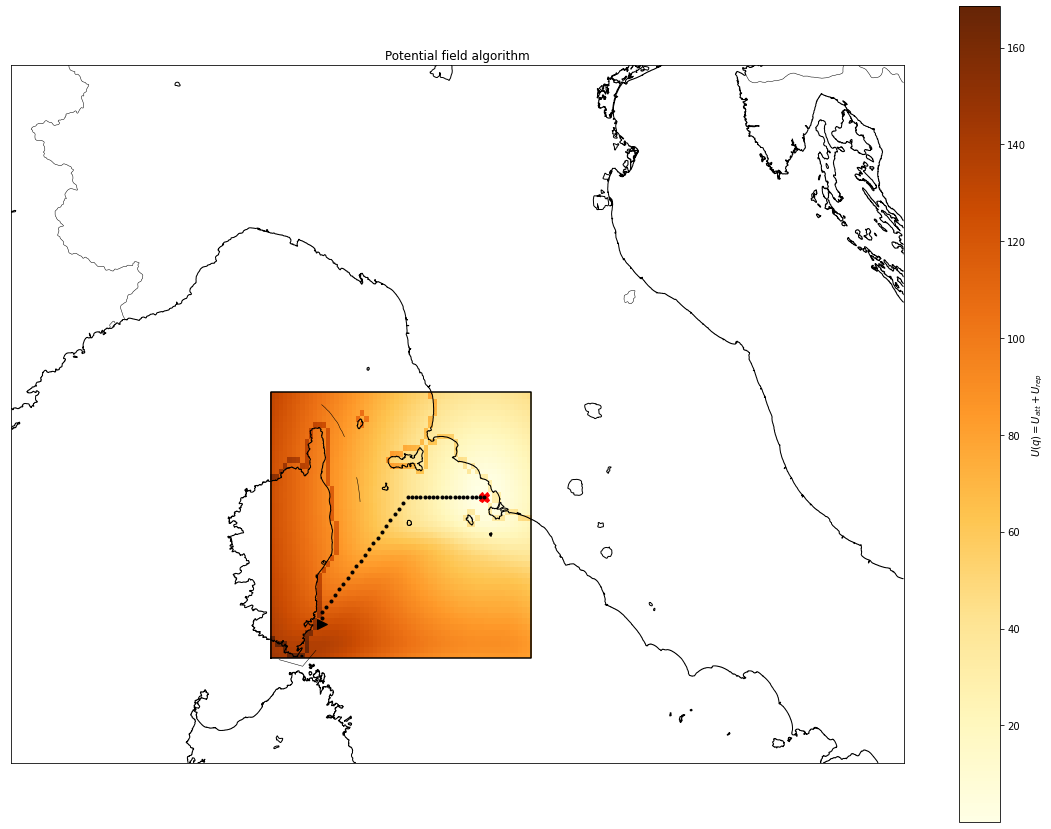

In [143]:
fig1 = plt.figure(1, figsize=(20, 15))
ax = fig1.add_subplot()
plt.pcolor(uxs_, uys_, plot_map1, cmap=cm.YlOrBr)
c_bar = plt.colorbar()
c_bar.set_label('$U(q)=U_{att}+U_{rep}$')
plt.plot(sx_init, sy_init, ">k", markersize=10)
plt.plot(gx_a, gy_a, "Xr", markersize=10)
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
plt.plot(path_x_, path_y_, '.k')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.title('Potential field algorithm')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [144]:
path_dist = 0
for i in range(len(path_x)-1):
    path_dist += distance(lonlat(*(path_x[i],path_y[i])), lonlat(*(path_x[i+1],path_y[i+1]))).km
print("Travel time = ", str(round(path_dist/18,4)), "hours")

Travel time =  10.3477 hours


# Attempt with force field

In [21]:
from APF3 import Vector2d, APF
# from APF3_improved import APF_Improved

In [24]:
obs = []
for i in range(len(oxmeteo_cx_cont)):
    obs.append([oxmeteo_cx_cont[i], oymeteo_cx_cont[i]])
for i in range(len(x_obsl)):
    obs.append([x_obsl[i], y_obsl[i]])

obs_ = []
for i in range(len(oxmeteo_cx_cont)):
    obs_.append([oxmeteo_cx_cont_[i], oymeteo_cx_cont_[i]])
for i in range(len(x_obsl)):
    obs_.append([x_obsl_[i], y_obsl_[i]])

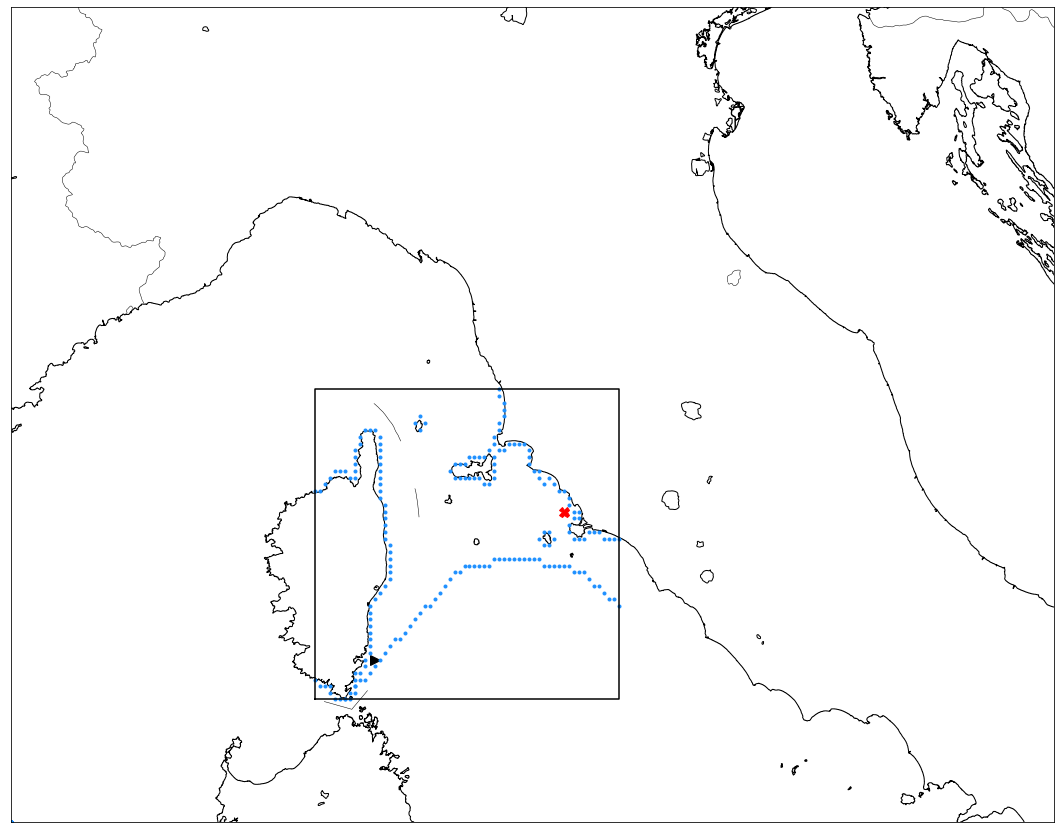

In [25]:
plt.figure(1, figsize=(20, 15))

plt.plot(sx_init, sy_init, ">k", markersize=10)
plt.plot(gx_a, gy_a, "Xr", markersize=10)
for i in range(len(obs)):
    plt.plot(obs[i][0], obs[i][1],'.', color="dodgerblue")
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [42]:
sx = xspace[12]  
sy = yspace[6] 
gx = xspace[50]   # 50
gy = yspace[28]   # 28
sx_init, sy_init = mp(sx, sy)
gx_a, gy_a = mp(gx, gy)

start = (sx, sy)
goal = (gx, gy)
grid_size = 0.04166
q_g = grid_size*5
k_att = 300

robot_radius = grid_size

k_att, k_rep = 1.0, 10.0
rr = grid_size
step_size, max_iters, goal_threshold = grid_size, 500, grid_size
step_size_ = grid_size*3

apf = APF_Improved(start, goal, obs, k_att, k_rep, rr, step_size, max_iters, goal_threshold, False)
apf.path_plan()
if apf.is_path_plan_success:
    path = apf.path
    path_ = []
    i = int(step_size_ / step_size)
    while i < len(path):
        path_.append(path[i])
        i += int(step_size_ / step_size)
    if path_[-1] != path[-1]:  # 添加最后一个点
        path_.append(path[-1])
    print('planed path points:{}'.format(path_))
    print('path plan success')
else:
    print('path plan failed')

planed path points:[[9.556827174017583, 41.70543736377334], [9.596301310199687, 41.76743291678321], [9.707128851209022, 41.82520190979698], [9.774119212596434, 41.903690878720376], [9.823015760178716, 41.97117178381441], [9.936943348964103, 42.022557627327465], [9.98024979879372, 42.080864595188686], [10.034665233202551, 42.146010117106435], [10.096950193158262, 42.21362207309796], [10.215803893915853, 42.252271758946954], [10.334657594673443, 42.29092144479595], [10.453511295431033, 42.32957113064494], [10.572364996188623, 42.36822081649393], [10.691218696946214, 42.40687050234292], [10.810072397703804, 42.4455201881919], [10.928926098461394, 42.48416987404089], [11.008161898966454, 42.50993633127354]]
path plan success


In [43]:
pathgeo = []
for i in range(len(path)):
    tempx, tempy = mp(path[i][0],path[i][1])
    pathgeo.append([tempx,tempy])
    
path_dist = 0
for i in range(len(path)-1):
    path_dist += distance(lonlat(*(path[i][0],path[i][1])), 
                          lonlat(*(path[i+1][0],path[i+1][1]))).km
print("Travel time = ", str(round(path_dist/18,4)), "hours")

Travel time =  10.3217 hours


In [193]:
len(path)

310

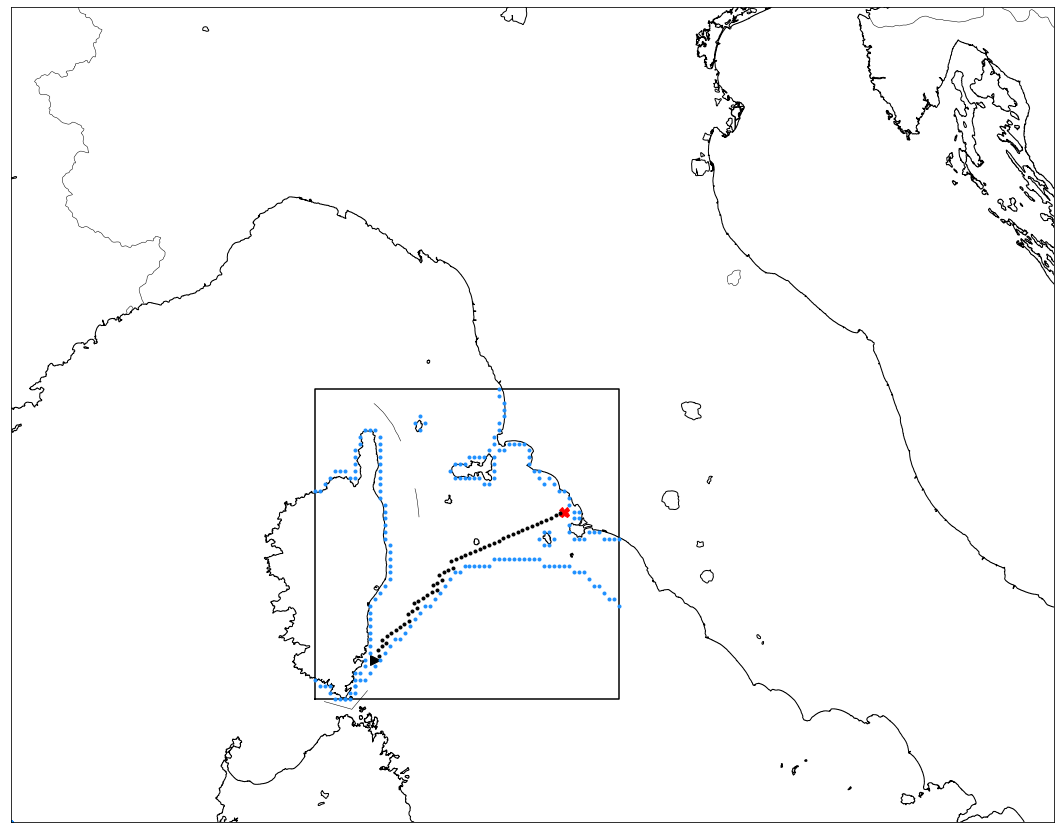

In [44]:
plt.figure(1, figsize=(20, 15))

plt.plot(sx_init, sy_init, ">k", markersize=10)
plt.plot(gx_a, gy_a, "Xr", markersize=10)
for i in range(len(pathgeo)):
    plt.plot(pathgeo[i][0], pathgeo[i][1],'.', color="k")
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
for i in range(len(obs)):
    plt.plot(obs[i][0], obs[i][1],'.', color="dodgerblue")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()


## Limit cycle

<ipython-input-4-b440cd3b115c>:43: RuntimeWarning: invalid value encountered in true_divide
  ax.quiver(x1, x2, dx1/rag, dx2/rag)


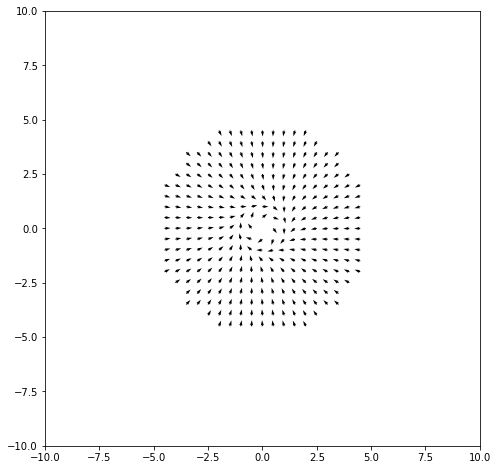

In [4]:
x = np.arange(-10,10,0.5)
y = np.arange(-10,10,0.5)

# Goal is at (40,40) 
goal = [8,8]
obstacle = [25,25]
obstacle2 = [25,25]
x1, x2 = np.meshgrid(x,y)
dx1 = np.zeros_like(x1)
dx2 = np.zeros_like(x2)
s = 5
r = 1
for i in range(len(x)):
    for j in range(len(y)):
        
        d_obstacle = np.sqrt((x1[i][j])**2 + (x2[i][j])**2)
        d_obstacle2 = np.sqrt((2-x1[i][j])**2 + (2-x2[i][j])**2)
        d_goal = np.sqrt((goal[0]-x1[i][j])**2 + ((goal[1]-x2[i][j]))**2)
        theta_goal = np.arctan2(goal[1] - x2[i][j], goal[0]  - x1[i][j])
#         if d_goal < r:
#             dx1[i][j] = 0
#             dx2[i][j] = 0
#         elif d_goal>r+s:
#             dx1[i][j] = +50* s *np.cos(theta_goal)
#             dx2[i][j] = +50 * s *np.sin(theta_goal)
#         else:
#             dx1[i][j] = +50 * (d_goal-r) *np.cos(theta_goal)
#             dx2[i][j] = +50 * (d_goal-r) *np.sin(theta_goal)
        if d_obstacle < 5:
            dx1[i][j] += 200*(+x2[i][j] + x1[i][j]*(1 - x1[i][j]*x1[i][j] - x2[i][j]*x2[i][j]))
            dx2[i][j] += 200*(-x1[i][j] + x2[i][j]*(1 - x1[i][j]*x1[i][j] - x2[i][j]*x2[i][j]))
#         if d_obstacle2 < 2:    
#             dx1[i][j] += 200*(+(x2[i][j]-2) + (x1[i][j]-2)*(2 - (x1[i][j]-2)*(x1[i][j]-2) - (x2[i][j]-2)*(x2[i][j]-2)))
#             dx2[i][j] += 200*(-(x1[i][j]-2) + (x2[i][j]-2)*(2 - (x1[i][j]-2)*(x1[i][j]-2) - (x2[i][j]-2)*(x2[i][j]-2)))
# dx1[i][j] = +x2[i][j] + x1*(1 - np.multiply(x1[i][j],x1[i]) - np.multiply(x2,x2))
# dx2 = -x1[i][j] + x2*(1 - np.multiply(x1,x1) - np.multiply(x2,x2))
rag = np.sqrt(np.multiply(dx1,dx1) + np.multiply(dx2,dx2))
# dx1 = x2
# dx2 = -mu*(np.multiply(x1,x2) - 1)*x2 - x1
            
seek_points = np.array([[-5,-5]]) 
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.quiver(x1, x2, dx1/rag, dx2/rag)
ax.set_aspect('equal', adjustable='box')
ax.streamplot(x1,x2,dx1,dx2, start_points=seek_points)
plt.xlim([-10, 10])
plt.ylim([-10, 10])
plt.show()
# ux = xspace
# uy = yspace
# uxs, uys = np.meshgrid(ux, uy)
# uxs_, uys_ = mp(uxs, uys)

# [x1, x2] = np.meshgrid(np.arange(-4,4,0.25),np.arange(-4,4,0.25))
# mu = 0.1
# dx1 = x2
# dx2 = -mu*(np.multiply(x1,x2) - 1)*x2 - x1
# r = np.sqrt(np.multiply(dx1,dx1) + np.multiply(dx2,dx2))
# seek_points = np.array([[4,0]]) 
# fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# ax.quiver(x1, x2, dx1/r, dx2/r)
# ax.set_aspect('equal', adjustable='box')
# ax.streamplot(x1,x2,dx1/r,dx2/r, start_points=seek_points)
# plt.xlim([-10, 10])
# plt.ylim([-10, 10])
# plt.show()

<ipython-input-13-5f5cb2324b14>:9: RuntimeWarning: invalid value encountered in true_divide
  ax.streamplot(x1, x2, dx1/r, dx2/r)


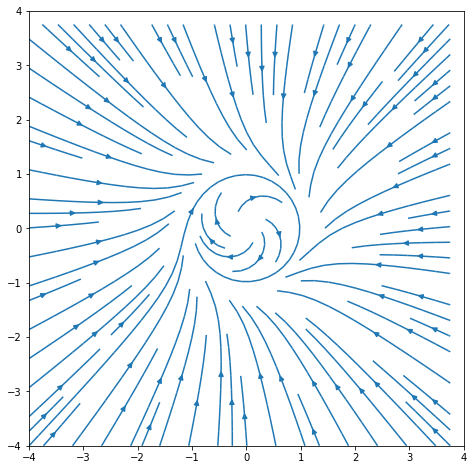

In [13]:
[x1, x2] = np.meshgrid(np.arange(-4,4,0.25),np.arange(-4,4,0.25))

dx1 = +x2 + (x1)*(1 - np.multiply(x1,x1) - np.multiply(x2,x2))
dx2 = -(x1) + (x2)*(1 - np.multiply(x1,x1) - np.multiply(x2,x2))
r = np.sqrt(np.multiply(dx1,dx1) + np.multiply(dx2,dx2))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# ax.quiver(x1, x2, dx1/r, dx2/r)
ax.streamplot(x1, x2, dx1/r, dx2/r)
ax.set_aspect('equal', adjustable='box')
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.show()

<ipython-input-287-a2a9e1343a81>:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mp.quiver(x1[points], x2[points], (dx1/r)[points], (dx2/r)[points], width=0.001, color='b')


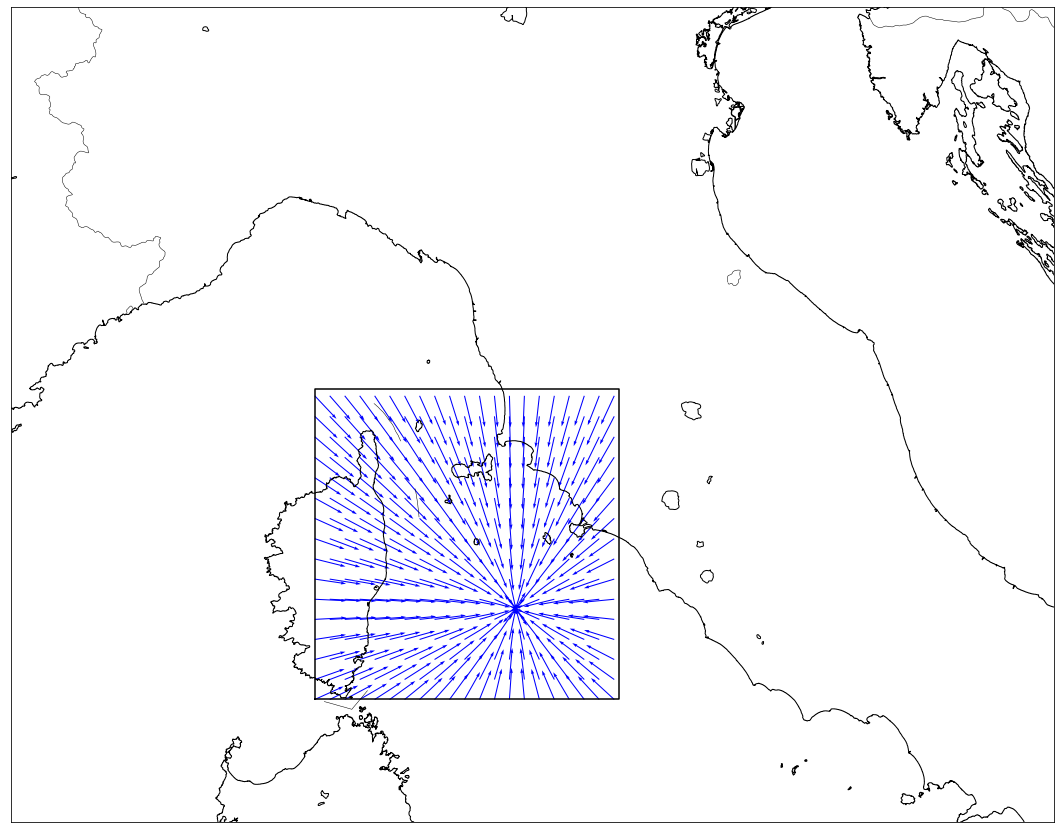

In [287]:
ux = xspace
uy = yspace
uxs, uys = np.meshgrid(ux, uy)
uxs_, uys_ = mp(uxs, uys)

[x1, x2] = mp(uxs,uys)

yy = np.arange(0, uys_.shape[0], 3)
xx = np.arange(0, uxs_.shape[1], 3)
points = np.meshgrid(yy, xx)



dx1 = +(x2-centroid[0][1]) + (x1-centroid[0][0])*(1 - np.multiply(x1-centroid[0][0],x1-centroid[0][0]) - np.multiply(x2-centroid[0][1],x2-centroid[0][1]))
dx2 = -(x1-centroid[0][0]) + (x2-centroid[0][1])*(1 - np.multiply(x1-centroid[0][0],x1-centroid[0][0]) - np.multiply(x2-centroid[0][1],x2-centroid[0][1]))
r = np.sqrt(np.multiply(dx1,dx1) + np.multiply(dx2,dx2))

fig, ax = plt.subplots(1, 1, figsize=(20, 15))
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.quiver(x1[points], x2[points], (dx1/r)[points], (dx2/r)[points], width=0.001, color='b')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

# Limit cycle

In [1527]:
import math
import random
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import time


class Vector2d:
    def __init__(self, x, y):
        self.deltaX = x
        self.deltaY = y
        self.length = -1
        self.direction = [0, 0]
        self.vector2d_share()

    def vector2d_share(self):
        if type(self.deltaX) == type(list()) and type(self.deltaY) == type(list()):
            deltaX, deltaY = self.deltaX, self.deltaY
            self.deltaX = deltaY[0] - deltaX[0]
            self.deltaY = deltaY[1] - deltaX[1]
            self.length = math.sqrt(self.deltaX ** 2 + self.deltaY ** 2) * 1.0
            if self.length > 0:
                self.direction = [self.deltaX / self.length, self.deltaY / self.length]
            else:
                self.direction = None
        else:
            self.length = math.sqrt(self.deltaX ** 2 + self.deltaY ** 2) * 1.0
            if self.length > 0:
                self.direction = [self.deltaX / self.length, self.deltaY / self.length]
            else:
                self.direction = None

    def __add__(self, other):
        vec = Vector2d(self.deltaX, self.deltaY)
        vec.deltaX += other.deltaX
        vec.deltaY += other.deltaY
        vec.vector2d_share()
        return vec

    def __sub__(self, other):
        vec = Vector2d(self.deltaX, self.deltaY)
        vec.deltaX -= other.deltaX
        vec.deltaY -= other.deltaY
        vec.vector2d_share()
        return vec

    def __mul__(self, other):
        vec = Vector2d(self.deltaX, self.deltaY)
        vec.deltaX *= other
        vec.deltaY *= other
        vec.vector2d_share()
        return vec

    def __truediv__(self, other):
        return self.__mul__(1.0 / other)

    def __repr__(self):
        return 'Vector deltaX:{}, deltaY:{}, length:{}, direction:{}'.format(self.deltaX, self.deltaY, self.length,
                                                                             self.direction)


class APF:

    def __init__(self, start: (), goal: (), obstacles: [], k_att: float, k_rep: float, rr: float,
                 step_size: float, max_iters: int, goal_threshold: float, is_plot=False):
        """
        :param start: 起点
        :param goal: 终点
        :param obstacles: 障碍物列表，每个元素为Vector2d对象
        :param k_att: 引力系数
        :param k_rep: 斥力系数
        :param rr: 斥力作用范围
        :param step_size: 步长
        :param max_iters: 最大迭代次数
        :param goal_threshold: 离目标点小于此值即认为到达目标点
        :param is_plot: 是否绘图
        """
        self.start = Vector2d(start[0], start[1])
        self.current_pos = Vector2d(start[0], start[1])
        self.goal = Vector2d(goal[0], goal[1])
        self.obstacles = [Vector2d(OB[0], OB[1]) for OB in obstacles]
        self.k_att = k_att
        self.k_rep = k_rep
        self.rr = rr
        self.step_size = step_size
        self.max_iters = max_iters
        self.iters = 0
        self.goal_threshold = goal_threshold
        self.path = list()
        self.is_path_plan_success = False
        self.is_plot = is_plot
        self.delta_t = 0.01
    def attractive(self):
        att = (self.goal - self.current_pos) * self.k_att  # conical potential
        return att

    def repulsion(self):
        rep = Vector2d(0, 0)
        for obstacle in self.obstacles:
            # obstacle = Vector2d(0, 0)
            t_vec = self.current_pos - obstacle
            if t_vec.length > self.rr:
                pass
            else:
                rep += Vector2d(t_vec.direction[0], t_vec.direction[1]) * self.k_rep * (
                        1.0 / t_vec.length - 1.0 / self.rr) / (t_vec.length ** 2)  # 方向由障碍物指向机器人
        return rep

    def path_plan(self):
        while self.iters < self.max_iters and (self.current_pos - self.goal).length > self.goal_threshold:
            
            f_vec = self.attractive() + self.repulsion()
            self.current_pos += Vector2d(f_vec.direction[0], f_vec.direction[1]) * self.step_size
            self.iters += 1
            self.path.append([self.current_pos.deltaX, self.current_pos.deltaY])
#             print(self.current_pos.deltaX,self.current_pos.deltaY)
            if self.is_plot:
                plt.plot(self.current_pos.deltaX, self.current_pos.deltaY, '.b')
                plt.pause(self.delta_t)
        if (self.current_pos - self.goal).length <= self.goal_threshold:
            self.is_path_plan_success = True

In [1528]:
def check_vec_angle(v1: Vector2d, v2: Vector2d):
    v1_v2 = v1.deltaX * v2.deltaX + v1.deltaY * v2.deltaY
    angle = math.acos(v1_v2 / (v1.length * v2.length)) * 180 / math.pi
    return angle


class APF_Improved(APF):
    def __init__(self, start: (), goal: (), obstacles: [], k_att: float, k_rep: float, rr: float,
                 step_size: float, max_iters: int, goal_threshold: float, is_plot=False):
        self.start = Vector2d(start[0], start[1])
        self.current_pos = Vector2d(start[0], start[1])
        self.goal = Vector2d(goal[0], goal[1])
        self.obstacles = [Vector2d(OB[0], OB[1]) for OB in obstacles]
        self.k_att = k_att
        self.k_rep = k_rep
        self.rr = rr  
        self.step_size = step_size
        self.max_iters = max_iters
        self.iters = 0
        self.goal_threshold = goal_threshold
        self.path = list()
        self.is_path_plan_success = False
        self.is_plot = is_plot
        self.delta_t = 0.01
        
    def repulsion(self):
        """
        #斥力计算, 改进斥力函数, 解决不可达问题
        #:return: 斥力大小
        """
        rep = Vector2d(0, 0) 
        obstacle = Vector2d(0, 0)
        list_dro = []  # list of distance robot-obstacle
        list_obs = []  # list of potentially disturbing obstacles
        
        for obstacle in self.obstacles:
            obs_to_rob = self.current_pos - obstacle
            if obs_to_rob.length < self.rr: 
                list_dro.append(obs_to_rob.length)
                list_obs.append(obstacle)
        if len(list_obs) == 0:  # no disturbing obstacles -> controller OFF
            rep = Vector2d(0, 0)
            return rep
        min_d_ro = min(list_dro)
        temp = list_dro.index(min_d_ro)
        closest_obs = list_obs[temp]
        
        obs_to_rob = self.current_pos - closest_obs
        
                
        """rep_1 = Vector2d(obs_to_rob.direction[0], obs_to_rob.direction[1]) * self.k_rep * (
                1.0 / obs_to_rob.length - 1.0 / self.rr) / (obs_to_rob.length ** 2) * (rob_to_goal.length ** 2)
        rep_2 = Vector2d(rob_to_goal.direction[0], rob_to_goal.direction[1]) * self.k_rep * ((1.0 / obs_to_rob.length - 1.0 / self.rr) ** 2) * rob_to_goal.length
        rep +=(rep_1+rep_2)"""

                #rep += Vector2d(+obs_to_rob.direction[1], -obs_to_rob.direction[0]) + Vector2d(obs_to_rob.deltaX, obs_to_rob.deltaY)*(9 - (obs_to_rob.deltaX)**2 - (obs_to_rob.deltaY)**2)
                #if obs_to_goal <
        rep = (Vector2d(-obs_to_rob.deltaY, +obs_to_rob.deltaX) + Vector2d(obs_to_rob.deltaX, obs_to_rob.deltaY)*(self.rr**2 - obs_to_rob.deltaX**2 - obs_to_rob.deltaY**2))*1000# *(1 - obs_to_rob.deltaX**2 - obs_to_rob.deltaY**2)
#         if self.current_pos.deltaX < 10:
#             rep = (Vector2d(+obs_to_rob.deltaY, -obs_to_rob.deltaX) + Vector2d(obs_to_rob.deltaX,obs_to_rob.deltaY)*(self.rr ** 2 - obs_to_rob.deltaX ** 2 - obs_to_rob.deltaY ** 2)) * 1000
        return rep
    
    
    

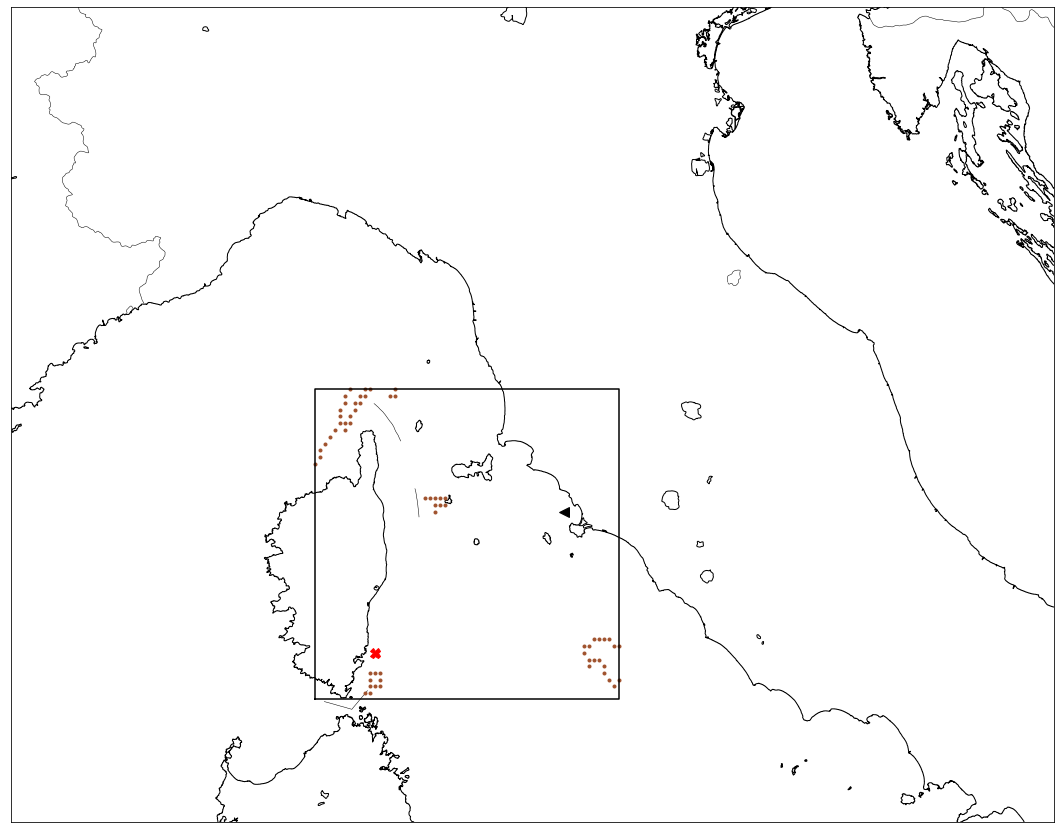

In [1529]:
plt.figure(1, figsize=(20, 15))

plt.plot(sx_init, sy_init, "<k", markersize=10)
plt.plot(gx_a, gy_a, "Xr", markersize=10)
plt.plot(map_x_2, map_y_2, '.', color="sienna")
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [1539]:
grid_size = 0.04166
rr = grid_size*1.5
step_size, max_iters, goal_threshold = grid_size, 500, grid_size
step_size_ = grid_size*3

sx = xspace[39]  
sy = yspace[33] 
gx = xspace[12]   # 50
gy = yspace[7]   # 28
sx_init, sy_init = mp(sx, sy)
gx_a, gy_a = mp(gx, gy)

start = (sx, sy)
goal = (gx, gy)

obs = []
for i in range(len(map_x2)):
    obs.append([map_x2[i], map_y2[i]])
#     obs.append([0,0])
    

In [1540]:
start_time = time.time()
apf = APF_Improved(start, goal, obs, 1, 0.8, rr, step_size, max_iters, goal_threshold, False)
apf.path_plan()
print("Computational time is {} seconds".format(time.time() - start_time))

path = apf.path
path_ = []
i = int(step_size_ / step_size)
while i < len(path):
    path_.append(path[i])
    i += int(step_size_ / step_size)
if path_[-1] != path[-1]:  # 添加最后一个点
    path_.append(path[-1])
# print('planed path points:{}'.format(path_))
if apf.is_path_plan_success:
    print('path plan success')
else:
    print('path plan failed')

Computational time is 0.03999924659729004 seconds
path plan success


In [1541]:
pathgeo = []
for i in range(len(path)):
    tempx, tempy = mp(path[i][0],path[i][1])
    pathgeo.append([tempx,tempy])
    
path_dist = 0
for i in range(len(path)-1):
    path_dist += distance(lonlat(*(path[i][0],path[i][1])), 
                          lonlat(*(path[i+1][0],path[i+1][1]))).km
print("Travel time = ", str(round(path_dist/18,4)), "hours")

Travel time =  8.1115 hours


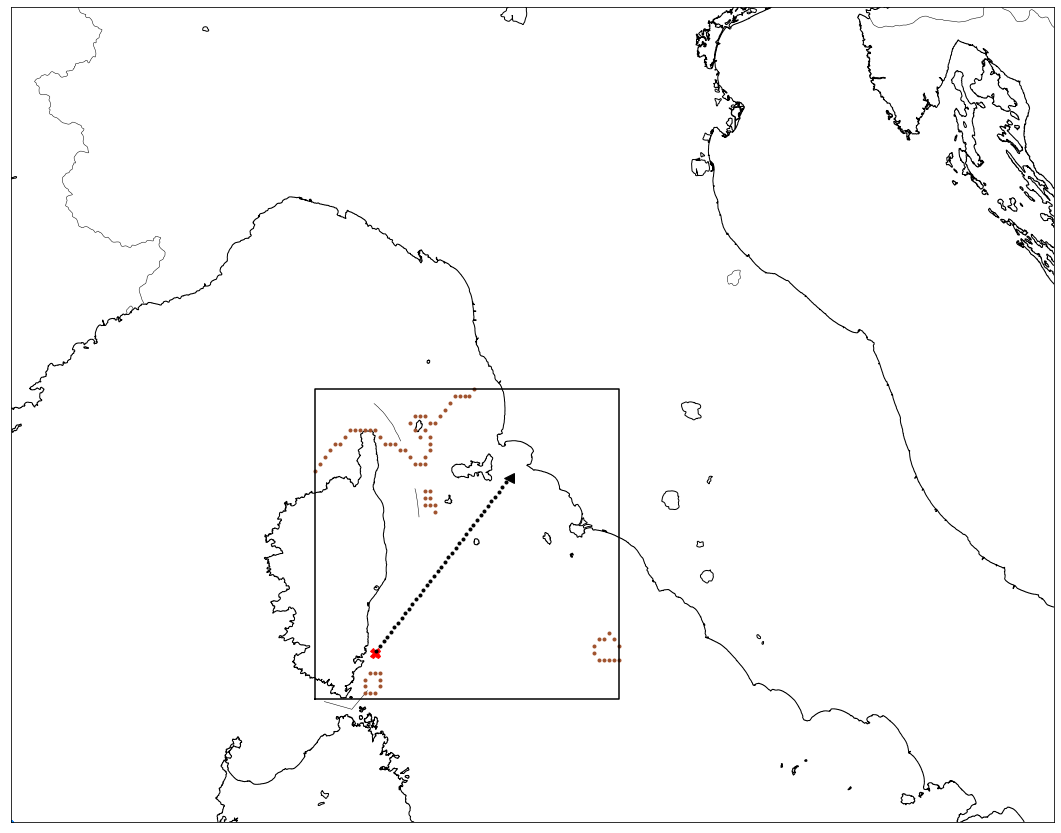

In [1542]:
plt.figure(1, figsize=(20, 15))

plt.plot(sx_init, sy_init, "<k", markersize=10)
plt.plot(gx_a, gy_a, "Xr", markersize=10)
plt.plot(map_x_2, map_y_2, '.', color="sienna")
for i in range(len(pathgeo)):
    plt.plot(pathgeo[i][0], pathgeo[i][1],'.', color="k")
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
for i in range(len(obs)):
    plt.plot(obs[i][0], obs[i][1],'.', color="dodgerblue")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [1148]:
# locapf50 = [[] for i in range(12)]
# locapf39 = [[] for i in range(12)]


In [1535]:
locapf50[11] = path

In [1543]:
locapf39[11] = path

In [1151]:
# locapf2.append(path)

In [1545]:
import pickle
file_name = "locapf39.pkl"
open_file = open(file_name, "wb")
pickle.dump(locapf39, open_file)
open_file.close()

# file_name = "locapf2.pkl"
# open_file = open(file_name, "rb")
# locapf2 = pickle.load(open_file)
# open_file.close()